In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import balanced_accuracy_score, confusion_matrix
from imblearn.metrics import classification_report_imbalanced

## Pre-Modeling

#### Assemble the data

In [17]:
bidders = pd.read_csv("./Resources/bidders.csv")
country_merch = pd.read_csv("./Resources/bidders_count_merch.csv")
train = pd.read_csv("./Resources/train.csv")

bidders = bidders.merge(country_merch, right_index=True, left_index=True)

merged_bidders = train.merge(bidders, how= "right", on="bidder_id")
merged_bidders.head()

,bidder_id,payment_account,address,outcome,auction_nunique_num,merchandise_nunique_num,device_nunique_num,country_nunique_num,ip_nunique_num,url_nunique_num,...,country_vi,country_nc,country_tc,country_gb,country_mp,country_gp,country_an,country_gi,country_gn,country_mh
0,91a3c57b13234af24875c56fb7e2b2f4rb56a,a3d2de7675556553a5f08e4c88d2c228754av,a3d2de7675556553a5f08e4c88d2c228vt0u4,0.0,18,1,14,6,20,1,...,0,0,0,0,0,0,0,0,0,0
1,624f258b49e77713fc34034560f93fb3hu3jo,a3d2de7675556553a5f08e4c88d2c228v1sga,ae87054e5a97a8f840a3991d12611fdcrfbq3,0.0,1,1,2,1,3,2,...,0,0,0,0,0,0,0,0,0,0
2,1c5f4fc669099bfbfac515cd26997bd12ruaj,a3d2de7675556553a5f08e4c88d2c2280cybl,92520288b50f03907041887884ba49c0cl0pd,0.0,4,1,2,1,4,2,...,0,0,0,0,0,0,0,0,0,0
3,4bee9aba2abda51bf43d639013d6efe12iycd,51d80e233f7b6a7dfdee484a3c120f3b2ita8,4cb9717c8ad7e88a9a284989dd79b98dbevyi,0.0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
4,4ab12bc61c82ddd9c2d65e60555808acqgos1,a3d2de7675556553a5f08e4c88d2c22857ddh,2a96c3ce94b3be921e0296097b88b56a7x1ji,0.0,23,1,53,2,123,91,...,0,0,0,0,0,0,0,0,0,0


Since each bidder in train dataset has corresponding unique payment account and address, and bidder_id is also a unique id that won't be useful for machine lerning. <br>
These three columns could be dropped.

In [18]:
merged_bidders = merged_bidders.drop(columns=["bidder_id", "payment_account", "address"])
merged_bidders.head()

,outcome,auction_nunique_num,merchandise_nunique_num,device_nunique_num,country_nunique_num,ip_nunique_num,url_nunique_num,time_mean,time_median,merchandise_homegoods,...,country_vi,country_nc,country_tc,country_gb,country_mp,country_gp,country_an,country_gi,country_gn,country_mh
0,0.0,18,1,14,6,20,1,5.711121e+11,3.458421e+11,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,1,1,2,1,3,2,3.233579e+12,3.233579e+12,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,4,1,2,1,4,2,2.379000e+12,2.532053e+12,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,1,1,1,1,1,1,3.201947e+12,1.864477e+12,0,...,0,0,0,0,0,0,0,0,0,0
4,0.0,23,1,53,2,123,91,7.777888e+10,1.368421e+10,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
merged_bidders.isnull().sum()

outcome                    0
auction_nunique_num        0
merchandise_nunique_num    0
device_nunique_num         0
country_nunique_num        0
                          ..
country_gp                 0
country_an                 0
country_gi                 0
country_gn                 0
country_mh                 0
Length: 217, dtype: int64

In [15]:
merged_bidders.to_csv("./Resources/merged_bidders.csv", index=False)

In [20]:
bidders.isnull().sum()

bidder_id                  0
auction_nunique_num        0
merchandise_nunique_num    0
device_nunique_num         0
country_nunique_num        0
                          ..
country_gp                 0
country_an                 0
country_gi                 0
country_gn                 0
country_mh                 0
Length: 217, dtype: int64

#### Spilt and scale the data

In [90]:
# Split our preprocessed data into features and target arrays
y = merged_bidders["outcome"].values
X = merged_bidders.drop(columns= "outcome", axis= 1).values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y, test_size=0.55)

# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [91]:
# Resample the training data with the BalancedRandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
model = BalancedRandomForestClassifier(n_estimators=500, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Accuracy Score: 0.8507923580711935
Confusion Matrix


C:\Users\Jarvinia\anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


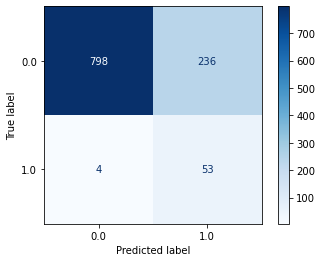

Classification Report:
                    pre       rec       spe        f1       geo       iba       sup

        0.0       1.00      0.77      0.93      0.87      0.85      0.71      1034
        1.0       0.18      0.93      0.77      0.31      0.85      0.73        57

avg / total       0.95      0.78      0.92      0.84      0.85      0.71      1091



In [92]:
print(f"Accuracy Score: {balanced_accuracy_score(y_test, y_pred)}")
# Plot the confusion matrix
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
print("Confusion Matrix")
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)  
plt.show()
print(f"Classification Report:\n {classification_report_imbalanced(y_test, y_pred)}")

In [100]:
# List the features sorted in descending order by feature importance
x = merged_bidders.drop(columns= "outcome", axis= 1)
import_score = model.fit(X_train, y_train).feature_importances_
import_rank = sorted(zip(import_score, x.columns), reverse=True)
importances = pd.DataFrame(import_rank, columns=["Feature Score", "Features"])
importances = importances[["Features", "Feature Score"]]
importances.head(10)

,Features,Feature Score
0,time_mean,0.149832
1,time_median,0.130390
2,auction_nunique_num,0.082178
3,ip_nunique_num,0.066887
4,device_nunique_num,0.052704
5,country_nunique_num,0.052678
6,url_nunique_num,0.048005
7,merchandise_homegoods,0.024025
8,merchandise_mobile,0.021673
9,merchandise_sportinggoods,0.017188


In [71]:
# Train the EasyEnsembleClassifier
from imblearn.ensemble import EasyEnsembleClassifier
model = EasyEnsembleClassifier(n_estimators=200 ,random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Accuracy Score: 0.8123875937425769
Confusion Matrix


C:\Users\Jarvinia\anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


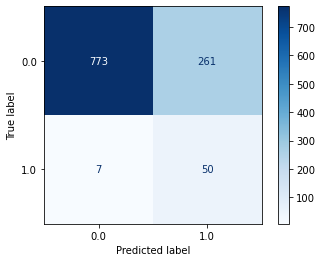

Classification Report:
                    pre       rec       spe        f1       geo       iba       sup

        0.0       0.99      0.75      0.88      0.85      0.81      0.65      1034
        1.0       0.16      0.88      0.75      0.27      0.81      0.66        57

avg / total       0.95      0.75      0.87      0.82      0.81      0.65      1091



In [72]:
print(f"Accuracy Score: {balanced_accuracy_score(y_test, y_pred)}")

# Plot the confusion matrix
print("Confusion Matrix")
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)  
plt.show()
print(f"Classification Report:\n {classification_report_imbalanced(y_test, y_pred)}")

In [73]:
from sklearn.ensemble import GradientBoostingClassifier
model = clf = GradientBoostingClassifier(n_estimators=200, random_state= 42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

Accuracy Score: 0.5916556381282025
Confusion Matrix


C:\Users\Jarvinia\anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


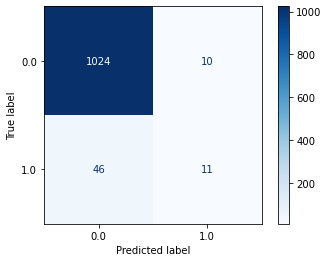

Classification Report:
                    pre       rec       spe        f1       geo       iba       sup

        0.0       0.96      0.99      0.19      0.97      0.44      0.21      1034
        1.0       0.52      0.19      0.99      0.28      0.44      0.18        57

avg / total       0.93      0.95      0.23      0.94      0.44      0.20      1091



In [74]:
print(f"Accuracy Score: {balanced_accuracy_score(y_test, y_pred)}")

# Plot the confusion matrix
print("Confusion Matrix")
plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues)  
plt.show()
print(f"Classification Report:\n {classification_report_imbalanced(y_test, y_pred)}")